In [263]:
%matplotlib inline



In [404]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import Model


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

import os
import glob
import cv2
import PIL
import imageio as im
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from pathlib import Path




In [405]:
directory = "/Users/gabriel1chiro/Developer/algoritmos sis inteligentes/labo deep learning/img-class/"

os.listdir(directory)


['.DS_Store', 'seg_test', 'seg_train', 'seg_pred']

In [306]:
train_set = os.path.join(directory, 'seg_train')
test_set = os.path.join(directory, 'seg_pred')
val_set = os.path.join(directory, 'seg_test')


In [297]:
image_size = (150, 150)
img_height,img_width =  image_size
batch_size = 32

## build dataset

In [132]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_set,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False)


Found 14034 files belonging to 6 classes.


In [133]:
val_ds  = tf.keras.utils.image_dataset_from_directory(
    val_set,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False)


Found 3000 files belonging to 6 classes.


In [134]:
train_dataset, val_ds

(<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [135]:
classes = train_dataset.class_names

In [136]:
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [137]:
plt.figure(figsize = (15,15))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classes[labels[i]])
        plt.axis('on')

In [ ]:
"""  
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
"""

## With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

In [ ]:
#inputs = keras.Input(shape=input_shape)
#x = data_augmentation(inputs)
#x = layers.Rescaling(1./255)(x)
# Rest of the model

## With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

In [ ]:
#augmented_train_ds = train_dataset.map(
#    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Apply `data_augmentation` to the training images.
#train_dataset = train_dataset.map(
#    lambda img, label: (data_augmentation(img), label),
#    num_parallel_calls=tf.data.AUTOTUNE,
#)
# Prefetching samples in GPU memory helps maximize GPU utilization.
#train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
#val_ds = val_ds.prefetch(tf.data.AUTOTUNE)



# Configure the dataset for performance


In [138]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [148]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [403]:

num_classes = len(classes)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [150]:
for layer in model.layers:
    print(layer.output_shape)

(None, 150, 150, 1)
(None, 150, 150, 1)
(None, 150, 150, 16)
(None, 75, 75, 16)
(None, 75, 75, 32)
(None, 37, 37, 32)
(None, 37, 37, 64)
(None, 18, 18, 64)
(None, 18, 18, 64)
(None, 20736)
(None, 128)
(None, 6)


In [351]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [352]:
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 150, 150, 1)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 150, 150, 1)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 150, 150, 16)      160       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                

## train

In [152]:
epochs=50
history = model.fit(
  train_dataset,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
439/439 [==============================] - 76s 164ms/step - loss: 1.1578 - accuracy: 0.5400 - val_loss: 1.1613 - val_accuracy: 0.5690
Epoch 2/50
439/439 [==============================] - 79s 179ms/step - loss: 0.9205 - accuracy: 0.6476 - val_loss: 1.0085 - val_accuracy: 0.5947
Epoch 3/50
439/439 [==============================] - 82s 186ms/step - loss: 0.8151 - accuracy: 0.6942 - val_loss: 0.8752 - val_accuracy: 0.6787
Epoch 4/50
439/439 [==============================] - 83s 190ms/step - loss: 0.7521 - accuracy: 0.7151 - val_loss: 0.9625 - val_accuracy: 0.6650
Epoch 5/50
439/439 [==============================] - 84s 192ms/step - loss: 0.6968 - accuracy: 0.7420 - val_loss: 0.7844 - val_accuracy: 0.7153
Epoch 6/50
439/439 [==============================] - 85s 194ms/step - loss: 0.6528 - accuracy: 0.7591 - val_loss: 0.7839 - val_accuracy: 0.7157
Epoch 7/50
439/439 [==============================] - 86s 197ms/step - loss: 0.6224 - accuracy: 0.7709 - val_loss: 0.7646 - val_ac

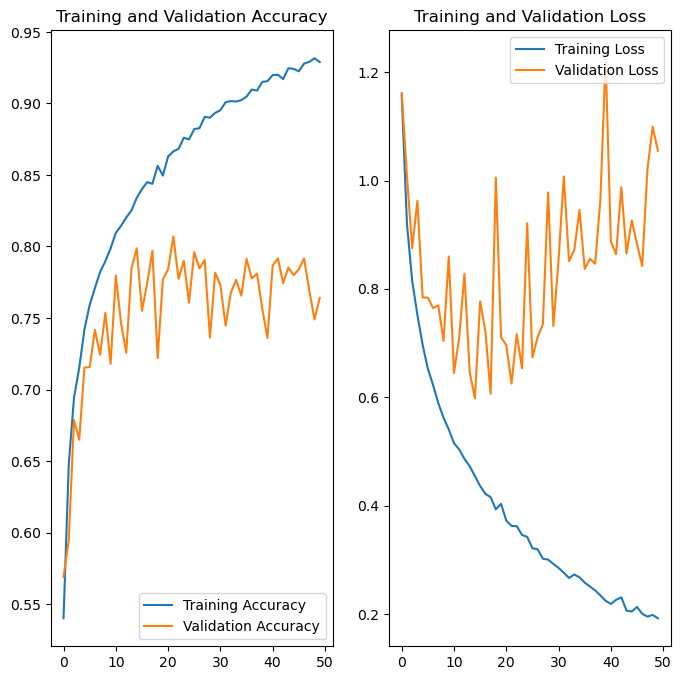

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## test

In [203]:

def load_and_preprocess_single_image(image_path, image_size):
    # Load the image from file
    img = load_img(image_path, color_mode='grayscale', target_size=image_size)

    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Scale the pixel values to [0,1]
    img_array = img_array / 255.

    # Add a batch dimension to the array
    img_array = img_array.reshape((1,) + img_array.shape)

    return img_array


In [311]:
test_set

'/Users/gabriel1chiro/Developer/algoritmos sis inteligentes/labo deep learning/img-class/seg_pred'

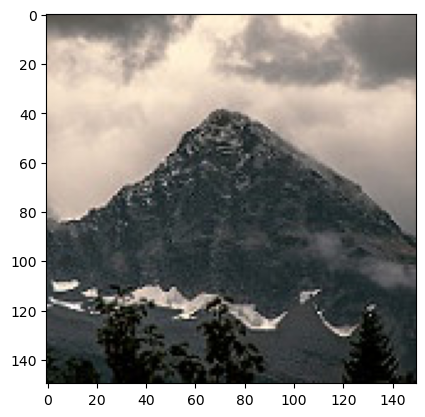

(1, 150, 150, 3)


In [313]:

#image_path = "/Users/gabriel1chiro/Developer/algoritmos sis inteligentes/labo deep learning/img-class/seg_test/forest/20056.jpg"
img_path = test_set + '/seg_pred/17704.jpg'
image_size = (150,150)

img = image.load_img(img_path, target_size=image_size)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)



In [314]:
img = load_and_preprocess_single_image(image_path, image_size)
# Make a prediction using the model
pred = model.predict(img)

score = tf.nn.softmax(pred[0])


1/1 [==============================] - 0s 30ms/step


In [301]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to forest with a 100.00 percent confidence.


In [302]:
test_datagen = ImageDataGenerator(
       rescale=1./255
   # preprocessing_function=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
)


In [315]:

test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale'  # Set the color mode to grayscale
)


Found 7301 images belonging to 1 classes.


In [309]:
model.evaluate(test_generator)

229/229 [==============================] - 5s 24ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

## export

In [278]:
import pickle


In [289]:
model.save('shapes_cnn.h5')


In [279]:
#for heavy model architectures, .h5 file is unsupported.
weigh= model.get_weights();    pklfile= "/Users/gabriel1chiro/Developer/algoritmos sis inteligentes/labo deep learning/modelweights.pkl"
try:
    fpkl= open(pklfile, 'wb')    #Python 3     
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()
    print("saved")
except:
    fpkl= open(pklfile, 'w')    #Python 2      
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()
    print("opened")


saved


## display 

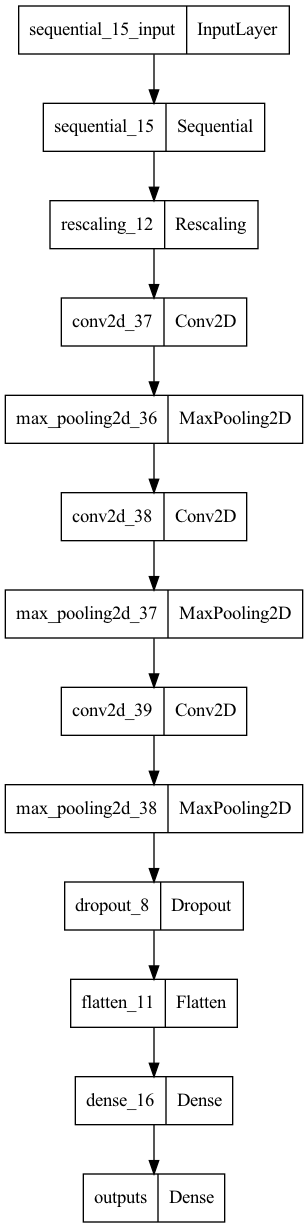

In [379]:
keras.utils.plot_model(model, to_file='model_plot.png')

In [388]:
input_layer = model.input
output_layer = model.layers[1].output  # choose the layer you want to visualize
activation_model = models.Model(inputs=input_layer, outputs=output_layer)


In [389]:
output_layer

<KerasTensor: shape=(None, 150, 150, 1) dtype=float32 (created by layer 'rescaling_12')>

In [365]:
input_layer

<KerasTensor: shape=(None, 150, 150, 1) dtype=float32 (created by layer 'sequential_15_input')>

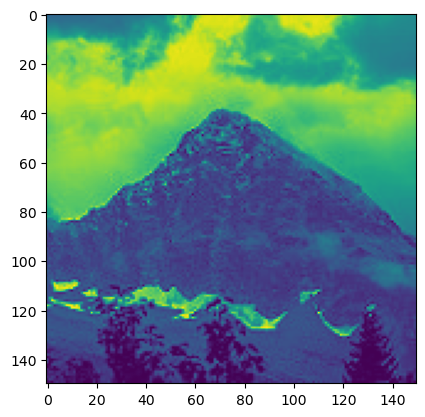

(1, 150, 150, 1)


In [343]:
#image_path = "/Users/gabriel1chiro/Developer/algoritmos sis inteligentes/labo deep learning/img-class/seg_test/forest/20056.jpg"
img_path = test_set + '/seg_pred/17704.jpg'
image_size = (150,150)

img = image.load_img(img_path,color_mode='grayscale', target_size=image_size)

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)


### The shape of the activations tensor would be (1, height, width, filters) where height and width correspond to the spatial dimensions of the activation maps, and filters is the number of filters in the layer. The first dimension of 1 corresponds to the batch size used during inference.


In [390]:
activations = activation_model.predict(img_tensor) 


1/1 [==============================] - 0s 171ms/step


In [391]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(150, 150, 1)


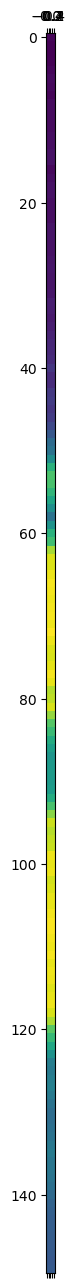

In [398]:
plt.matshow(first_layer_activation[0,:,:], cmap='viridis')


/var/folders/qj/2jp6hl0n1jddh5lltpjmdkmc0000gn/T/ipykernel_15192/3999637139.py:29: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
/Users/gabriel1chiro/opt/anaconda3/envs/tf/lib/python3.10/site-packages/matplotlib/_tight_bbox.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/gabriel1chiro/opt/anaconda3/envs/tf/lib/python3.10/site-packages/matplotlib/_tight_bbox.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/gabriel1chiro/opt/anaconda3/envs/tf/lib/python3.10/site-packages/matplotlib/patches.py:739: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/gabriel1chiro/opt/anaconda3/envs/tf/lib/python3.10/site-packages/matplotlib/transforms.py:2042: RuntimeWarning: i

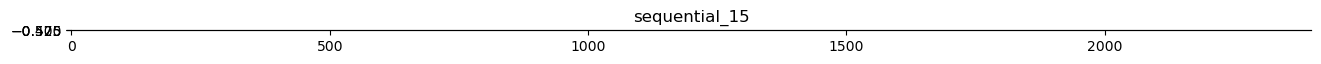

In [401]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')